<a href="https://colab.research.google.com/github/CallumCoffey/ANN/blob/main/3_2_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Artificial Neural Networks and Deep Learning  



##Assignment 3.2 - Convolutional Neural Networks

Prof. Dr. Ir. Johan A. K. Suykens     

In this file, we will implement a convolutional neural network from scratch.

We only consider classification tasks here in the session.




In [ ]:
# # Please first load your google drive
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# # Please go to Edit > Notebook settings > Hardware accelerator > choose "T4 GPU"
# # Now check if you have loaded the GPU successfully
# !nvidia-smi

# Convolutional Neural Networks
In this section, we implement CNN from scrath and train it on the MNIST dataset.

We first load the dataset as follows:

In [ ]:
import torch
from torch import nn, optim, functional, utils
from torch.utils.data.dataloader import DataLoader
import torchvision
from torchvision import datasets, utils
from torchvision.datasets import MNIST

import time, os

import matplotlib.pyplot as plt
# use seaborn
import seaborn as sns

# Apply the default theme
sns.set_theme()
plt.rcParams["figure.dpi"] = 100
plt.rcParams['savefig.dpi'] = 300


def get_mnist_loader(batch_size=100, num_train_samples = 10000, num_test_samples = 2000):
    """

    :return: train_loader, test_loader
    """
    train_dataset = MNIST(root='../data',
                          train=True,
                          transform=torchvision.transforms.ToTensor(),
                          download=True)
    test_dataset = MNIST(root='../data',
                         train=False,
                         transform=torchvision.transforms.ToTensor(),
                         download=True)

    # Randomly select a subset of samples
    train_indices = torch.randperm(len(train_dataset))[:num_train_samples]
    test_indices = torch.randperm(len(test_dataset))[:num_test_samples]

    # Create subset samplers to be used in the dataloader
    train_subset_sampler = torch.utils.data.SubsetRandomSampler(train_indices)
    test_subset_sampler = torch.utils.data.SubsetRandomSampler(test_indices)

    train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                               batch_size=batch_size,
                                               sampler = train_subset_sampler)
    test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                              batch_size=batch_size,
                                              sampler = test_subset_sampler)


    return train_loader, test_loader

## Build CNN from scratch
Our CNN is of 4 convolutional layers and 2 fully connected layers.
You can try a different amount of layers by simply add more ``self.conv`` layers inside  ``__init__`` and ``forward`` in the following code. Please be careful with the dimensions of the convolutional layers when changing parameters such as convolution channels, kernel_size and stride.

In [ ]:
class CNNnet(torch.nn.Module):
    def __init__(self):
        super(CNNnet,self).__init__()
        self.conv1 = torch.nn.Sequential(
            # 2-D convolution
            torch.nn.Conv2d(in_channels=1, # input channels
                            out_channels=16, # convolution channels
                            kernel_size=3, # kernel size of the convolution
                            stride=2, # stride of the kernel
                            padding=1), # padding with 0
            # Data is normalized before entering ReLU，num_features=batch_size*num_features*height*width
            # Output is with size (N,C,W,H), i.e., (batch_size, channels, width, height)
            torch.nn.BatchNorm2d(16), # the input dimensionality of BatchNorm2d should match the number of convolution channels
            # Set activation function
            torch.nn.ReLU()
        )
        self.conv2 = torch.nn.Sequential(
            torch.nn.Conv2d(16,32,3,2,1), # be sure to have the number of input channels match the output channels of the previous layer
            torch.nn.BatchNorm2d(32),
            torch.nn.ReLU()
        )
        self.conv3 = torch.nn.Sequential(
            torch.nn.Conv2d(32,32,3,2,1),
            torch.nn.BatchNorm2d(32),
            torch.nn.ReLU()
        )
        self.conv4 = torch.nn.Sequential(
            torch.nn.Conv2d(32,64,2,2,0),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU()
        )

        # set fully connected layer
        self.mlp1 = torch.nn.Linear(2*2*64,100) # input dimension should match the output dimension from the previous layer
        # final output is of dimension 10 since
        # MNIST is a 10-class classification dataset
        self.mlp2 = torch.nn.Linear(100,10)

    # feedforward
    def forward(self,x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        # flatten tensor to 1-D
        x = self.mlp1(x.view(x.size(0),-1))
        x = self.mlp2(x)
        return x

## Training function
The training process includes loading the model, setting the optimizer, and running on the training set for epochs.
After each training epoch, we evaluate the model on the test set to record the test accuracy.

In [ ]:
def train(model, train_epoch, model_save, train_loader, test_loader) :
    # Push model on to GPU if available
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    loss_func = nn.CrossEntropyLoss( )
    # Use Adam optimizer
    optimizer = torch.optim.Adam(model.parameters( ),lr=0.001)

    acc_count = []  # record the test accuracy
    for epoch in range(train_epoch):

        model.train()

        for i, (x, y) in enumerate(train_loader):
            x = x.to(device)  # torch,Size([128,1,28,28])
            y = y.to(device)   # torch.Size([128])
            # Output of the model
            out = model(x)  # torch.Size([128,10])
            # Compute loss
            loss = loss_func(out, y)

            optimizer.zero_grad()
            loss.backward()  # backpropagation
            optimizer.step()  # update the network parameters

            # save the model checkpoint every 20 iterations
            if i % 20 == 0:
                print('Training Loss:{:.6f} Batch {}/{} '.format(loss.item(), i, len(train_loader)))
                torch.save(model, model_save)

        # evaluate the model after each training epoch
        with torch.no_grad():
            model.eval()

            true_pred = torch.zeros(1).to(device)
            nb_sample = 0

            for inputs, targets in test_loader:
                inputs = inputs.to(device)
                targets = targets.to(device)
                outputs = model(inputs)

                _, pred = torch.max(outputs, dim=1)

                true_pred = true_pred + torch.sum(pred == targets).type(torch.FloatTensor)
                nb_sample += len(inputs)

            acc = true_pred / nb_sample
            acc = acc.item()

            acc_count.append(acc)

            print('Epoch {:d}, Test Accuracy {:.3f} %'.format(epoch, acc * 100))

    return acc_count

## Let's start training!
The network is trained for 20 epochs, batch size of 100.

You can adjust the hyperparameters here if necessary.

In [ ]:
acc_list = [0,0,0]
# load datasets
train_loader, test_loader = get_mnist_loader(batch_size=batch_size)

In [ ]:
# You can adjust the hyperparameters here if needed
train_epoch = 30
batch_size = 200
shuffle = True

In [ ]:
#original
class CNNnet(torch.nn.Module):
    def __init__(self):
        super(CNNnet,self).__init__()
        self.conv1 = torch.nn.Sequential(
            torch.nn.Conv2d(1,16,3,2,1),
            torch.nn.BatchNorm2d(16),
            torch.nn.ReLU()
        )
        self.conv2 = torch.nn.Sequential(
            torch.nn.Conv2d(16,32,3,2,1), # be sure to have the number of input channels match the output channels of the previous layer
            torch.nn.BatchNorm2d(32),
            torch.nn.ReLU()
        )
        self.conv3 = torch.nn.Sequential(
            torch.nn.Conv2d(32,32,3,2,1),
            torch.nn.BatchNorm2d(32),
            torch.nn.ReLU()
        )
        self.conv4 = torch.nn.Sequential(
            torch.nn.Conv2d(32,64,2,2,0),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU()
        )

        # set fully connected layer
        self.mlp1 = torch.nn.Linear(2*2*64,100) # input dimension should match the output dimension from the previous layer
        # final output is of dimension 10 since
        # MNIST is a 10-class classification dataset
        self.mlp2 = torch.nn.Linear(100,10)

    # feedforward
    def forward(self,x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        # flatten tensor to 1-D
        x = self.mlp1(x.view(x.size(0),-1))
        x = self.mlp2(x)
        return x
model = CNNnet()

# train the model
original = train(model, train_epoch=train_epoch, model_save=model_save, train_loader=train_loader, test_loader=test_loader)

Training Loss:2.353777 Batch 0/100 
Training Loss:0.827614 Batch 20/100 
Training Loss:0.320106 Batch 40/100 
Training Loss:0.280404 Batch 60/100 
Training Loss:0.247116 Batch 80/100 
Epoch 0, Test Accuracy 94.200 %
Training Loss:0.258573 Batch 0/100 
Training Loss:0.096135 Batch 20/100 
Training Loss:0.110106 Batch 40/100 
Training Loss:0.075332 Batch 60/100 
Training Loss:0.093462 Batch 80/100 
Epoch 1, Test Accuracy 96.400 %
Training Loss:0.067235 Batch 0/100 
Training Loss:0.023256 Batch 20/100 
Training Loss:0.056111 Batch 40/100 
Training Loss:0.138461 Batch 60/100 
Training Loss:0.029332 Batch 80/100 
Epoch 2, Test Accuracy 96.350 %
Training Loss:0.049443 Batch 0/100 
Training Loss:0.072415 Batch 20/100 
Training Loss:0.042462 Batch 40/100 
Training Loss:0.022879 Batch 60/100 
Training Loss:0.034626 Batch 80/100 
Epoch 3, Test Accuracy 96.150 %
Training Loss:0.015541 Batch 0/100 
Training Loss:0.008114 Batch 20/100 
Training Loss:0.013315 Batch 40/100 
Training Loss:0.007078 Bat

In [ ]:
#3 layers
class CNNnet(torch.nn.Module):
    def __init__(self):
        super(CNNnet,self).__init__()
        self.conv1 = torch.nn.Sequential(
            torch.nn.Conv2d(1,16,3,2,1),
            torch.nn.BatchNorm2d(16),
            torch.nn.ReLU()
        )
        self.conv2 = torch.nn.Sequential(
            torch.nn.Conv2d(16,32,3,2,1), # be sure to have the number of input channels match the output channels of the previous layer
            torch.nn.BatchNorm2d(32),
            torch.nn.ReLU()
        )
        self.conv3 = torch.nn.Sequential(
            torch.nn.Conv2d(32,64,2,2,0),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU()
        )

        print((32 - 2 + 2 * 0 ) / 2 + 1)

        # set fully connected layer
        self.mlp1 = torch.nn.Linear(3*3*64,100) # input dimension should match the output dimension from the previous layer
        # final output is of dimension 10 since
        # MNIST is a 10-class classification dataset
        self.mlp2 = torch.nn.Linear(100,10)

    # feedforward
    def forward(self,x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        # flatten tensor to 1-D
        x = self.mlp1(x.view(x.size(0),-1))
        x = self.mlp2(x)
        return x

model = CNNnet()

# train the model
lessLayer = train(model, train_epoch=train_epoch, model_save=model_save, train_loader=train_loader, test_loader=test_loader)

16.0
Training Loss:2.352909 Batch 0/100 
Training Loss:0.769769 Batch 20/100 
Training Loss:0.271719 Batch 40/100 
Training Loss:0.226057 Batch 60/100 
Training Loss:0.188903 Batch 80/100 
Epoch 0, Test Accuracy 94.800 %
Training Loss:0.188195 Batch 0/100 
Training Loss:0.130259 Batch 20/100 
Training Loss:0.190839 Batch 40/100 
Training Loss:0.119231 Batch 60/100 
Training Loss:0.156444 Batch 80/100 
Epoch 1, Test Accuracy 96.150 %
Training Loss:0.076585 Batch 0/100 
Training Loss:0.073405 Batch 20/100 
Training Loss:0.134941 Batch 40/100 
Training Loss:0.119965 Batch 60/100 
Training Loss:0.033988 Batch 80/100 
Epoch 2, Test Accuracy 96.650 %
Training Loss:0.050309 Batch 0/100 
Training Loss:0.068318 Batch 20/100 
Training Loss:0.031193 Batch 40/100 
Training Loss:0.103168 Batch 60/100 
Training Loss:0.057823 Batch 80/100 
Epoch 3, Test Accuracy 97.550 %
Training Loss:0.022808 Batch 0/100 
Training Loss:0.063402 Batch 20/100 
Training Loss:0.016734 Batch 40/100 
Training Loss:0.01118

In [ ]:
#5 layers
class CNNnet(torch.nn.Module):
    def __init__(self):
        super(CNNnet,self).__init__()
        self.conv1 = torch.nn.Sequential(
            # 2-D convolution
            torch.nn.Conv2d(1,16,3,2,1),
            torch.nn.BatchNorm2d(16),
            torch.nn.ReLU()
        )
        self.conv2 = torch.nn.Sequential(
            torch.nn.Conv2d(16,32,3,2,1),
            torch.nn.ReLU()
        )
        self.conv3 = torch.nn.Sequential(
            torch.nn.Conv2d(32,32,3,2,1),
            torch.nn.BatchNorm2d(32),
            torch.nn.ReLU()
        )
        self.conv4 = torch.nn.Sequential(
            torch.nn.Conv2d(32,32,3,2,1),
            torch.nn.BatchNorm2d(32),
            torch.nn.ReLU()
        )
        self.conv5 = torch.nn.Sequential(
            torch.nn.Conv2d(32,64,2,2,0),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU()
        )

        # set fully connected layer
        self.mlp1 = torch.nn.Linear(1*1*64,100) # input dimension should match the output dimension from the previous layer
        # final output is of dimension 10 since
        # MNIST is a 10-class classification dataset
        self.mlp2 = torch.nn.Linear(100,10)

    # feedforward
    def forward(self,x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        # flatten tensor to 1-D
        x = self.mlp1(x.view(x.size(0),-1))
        x = self.mlp2(x)
        return x

model = CNNnet()

# train the model
moreLayer = train(model, train_epoch=train_epoch, model_save=model_save, train_loader=train_loader, test_loader=test_loader)

Training Loss:2.329518 Batch 0/100 
Training Loss:1.152006 Batch 20/100 
Training Loss:0.580845 Batch 40/100 
Training Loss:0.294385 Batch 60/100 
Training Loss:0.107953 Batch 80/100 
Epoch 0, Test Accuracy 93.300 %
Training Loss:0.189784 Batch 0/100 
Training Loss:0.106722 Batch 20/100 
Training Loss:0.154559 Batch 40/100 
Training Loss:0.212365 Batch 60/100 
Training Loss:0.175430 Batch 80/100 
Epoch 1, Test Accuracy 96.150 %
Training Loss:0.101812 Batch 0/100 
Training Loss:0.182515 Batch 20/100 
Training Loss:0.147908 Batch 40/100 
Training Loss:0.077413 Batch 60/100 
Training Loss:0.050019 Batch 80/100 
Epoch 2, Test Accuracy 96.700 %
Training Loss:0.047640 Batch 0/100 
Training Loss:0.124475 Batch 20/100 
Training Loss:0.155263 Batch 40/100 
Training Loss:0.056424 Batch 60/100 
Training Loss:0.037203 Batch 80/100 
Epoch 3, Test Accuracy 96.450 %
Training Loss:0.029895 Batch 0/100 
Training Loss:0.018476 Batch 20/100 
Training Loss:0.060507 Batch 40/100 
Training Loss:0.036877 Bat

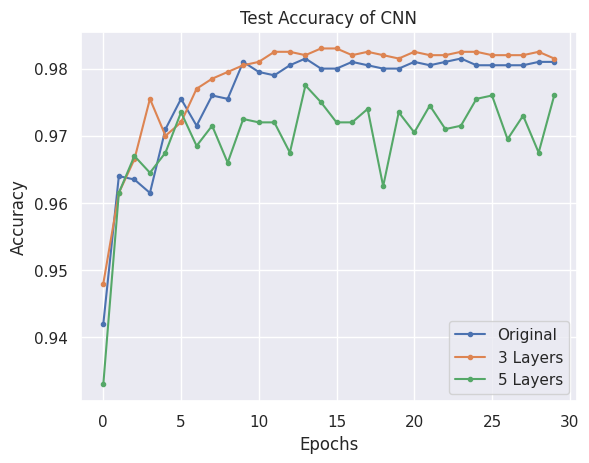

In [ ]:
# Plot the accuracy curves w.r.t. epochs
plt.plot(original, marker='.', label='Original')
plt.plot(lessLayer, marker='.',label='3 Layers')
plt.plot(moreLayer, marker='.',label='5 Layers')
plt.legend()
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.title('Test Accuracy of CNN')
plt.show()

In [ ]:
#Decrease Kernel to 2
class CNNnet(torch.nn.Module):
    def __init__(self):
        super(CNNnet,self).__init__()
        self.conv1 = torch.nn.Sequential(
            # 2-D convolution
            torch.nn.Conv2d(in_channels=1, # input channels
                            out_channels=16, # convolution channels
                            kernel_size=2, # kernel size of the convolution
                            stride=2, # stride of the kernel
                            padding=1), # padding with 0
            # Data is normalized before entering ReLU，num_features=batch_size*num_features*height*width
            # Output is with size (N,C,W,H), i.e., (batch_size, channels, width, height)
            torch.nn.BatchNorm2d(16), # the input dimensionality of BatchNorm2d should match the number of convolution channels
            # Set activation function
            torch.nn.ReLU()
        )
        self.conv2 = torch.nn.Sequential(
            torch.nn.Conv2d(16,32,2,2,1), # be sure to have the number of input channels match the output channels of the previous layer
            torch.nn.BatchNorm2d(32),
            torch.nn.ReLU()
        )
        self.conv3 = torch.nn.Sequential(
            torch.nn.Conv2d(32,32,2,2,1),
            torch.nn.BatchNorm2d(32),
            torch.nn.ReLU()
        )
        self.conv4 = torch.nn.Sequential(
            torch.nn.Conv2d(32,64,2,2,0),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU()
        )

        # set fully connected layer
        self.mlp1 = torch.nn.Linear(2*2*64,100) # input dimension should match the output dimension from the previous layer
        # final output is of dimension 10 since
        # MNIST is a 10-class classification dataset
        self.mlp2 = torch.nn.Linear(100,10)

    # feedforward
    def forward(self,x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        # flatten tensor to 1-D
        x = self.mlp1(x.view(x.size(0),-1))
        x = self.mlp2(x)
        return x
model = CNNnet()

# train the model
lessKernel = train(model, train_epoch=train_epoch, model_save=model_save, train_loader=train_loader, test_loader=test_loader)

Training Loss:2.368018 Batch 0/100 
Training Loss:1.105368 Batch 20/100 
Training Loss:0.606484 Batch 40/100 
Training Loss:0.452784 Batch 60/100 
Training Loss:0.409013 Batch 80/100 
Epoch 0, Test Accuracy 93.000 %
Training Loss:0.278593 Batch 0/100 
Training Loss:0.167733 Batch 20/100 
Training Loss:0.227303 Batch 40/100 
Training Loss:0.268233 Batch 60/100 
Training Loss:0.264597 Batch 80/100 
Epoch 1, Test Accuracy 94.700 %
Training Loss:0.201655 Batch 0/100 
Training Loss:0.099584 Batch 20/100 
Training Loss:0.224281 Batch 40/100 
Training Loss:0.064905 Batch 60/100 
Training Loss:0.051916 Batch 80/100 
Epoch 2, Test Accuracy 96.000 %
Training Loss:0.051160 Batch 0/100 
Training Loss:0.094771 Batch 20/100 
Training Loss:0.135679 Batch 40/100 
Training Loss:0.039725 Batch 60/100 
Training Loss:0.209175 Batch 80/100 
Epoch 3, Test Accuracy 96.100 %
Training Loss:0.069511 Batch 0/100 
Training Loss:0.115506 Batch 20/100 
Training Loss:0.035966 Batch 40/100 
Training Loss:0.030356 Bat

In [ ]:
#Increase Kernel to 4
class CNNnet(torch.nn.Module):
    def __init__(self):
        super(CNNnet,self).__init__()
        self.conv1 = torch.nn.Sequential(
            # 2-D convolution
            torch.nn.Conv2d(in_channels=1, # input channels
                            out_channels=16, # convolution channels
                            kernel_size=4, # kernel size of the convolution
                            stride=2, # stride of the kernel
                            padding=1), # padding with 0
            # Data is normalized before entering ReLU，num_features=batch_size*num_features*height*width
            # Output is with size (N,C,W,H), i.e., (batch_size, channels, width, height)
            torch.nn.BatchNorm2d(16), # the input dimensionality of BatchNorm2d should match the number of convolution channels
            # Set activation function
            torch.nn.ReLU()
        )
        self.conv2 = torch.nn.Sequential(
            torch.nn.Conv2d(16,32,4,2,1), # be sure to have the number of input channels match the output channels of the previous layer
            torch.nn.BatchNorm2d(32),
            torch.nn.ReLU()
        )
        self.conv3 = torch.nn.Sequential(
            torch.nn.Conv2d(32,32,3,2,1),
            torch.nn.BatchNorm2d(32),
            torch.nn.ReLU()
        )
        self.conv4 = torch.nn.Sequential(
            torch.nn.Conv2d(32,64,2,2,0),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU()
        )

        # set fully connected layer
        self.mlp1 = torch.nn.Linear(2*2*64,100) # input dimension should match the output dimension from the previous layer
        # final output is of dimension 10 since
        # MNIST is a 10-class classification dataset
        self.mlp2 = torch.nn.Linear(100,10)

    # feedforward
    def forward(self,x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        # flatten tensor to 1-D
        x = self.mlp1(x.view(x.size(0),-1))
        x = self.mlp2(x)
        return x
model = CNNnet()

# train the model
moreKernel = train(model, train_epoch=train_epoch, model_save=model_save, train_loader=train_loader, test_loader=test_loader)

Training Loss:2.323471 Batch 0/100 
Training Loss:0.810507 Batch 20/100 
Training Loss:0.394662 Batch 40/100 
Training Loss:0.326212 Batch 60/100 
Training Loss:0.219779 Batch 80/100 
Epoch 0, Test Accuracy 95.350 %
Training Loss:0.176942 Batch 0/100 
Training Loss:0.151555 Batch 20/100 
Training Loss:0.177169 Batch 40/100 
Training Loss:0.158622 Batch 60/100 
Training Loss:0.069792 Batch 80/100 
Epoch 1, Test Accuracy 96.200 %
Training Loss:0.031655 Batch 0/100 
Training Loss:0.076455 Batch 20/100 
Training Loss:0.046077 Batch 40/100 
Training Loss:0.070437 Batch 60/100 
Training Loss:0.045203 Batch 80/100 
Epoch 2, Test Accuracy 96.750 %
Training Loss:0.019607 Batch 0/100 
Training Loss:0.026865 Batch 20/100 
Training Loss:0.058821 Batch 40/100 
Training Loss:0.060762 Batch 60/100 
Training Loss:0.026080 Batch 80/100 
Epoch 3, Test Accuracy 96.750 %
Training Loss:0.040914 Batch 0/100 
Training Loss:0.062042 Batch 20/100 
Training Loss:0.016274 Batch 40/100 
Training Loss:0.006888 Bat

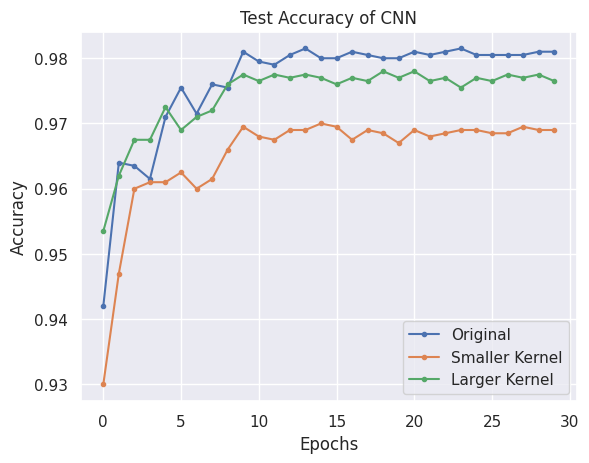

In [ ]:
# Plot the accuracy curves w.r.t. epochs
plt.plot(original, marker='.', label='Original')
plt.plot(lessKernel, marker='.',label='Smaller Kernel')
plt.plot(moreKernel, marker='.',label='Larger Kernel')
plt.legend()
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.title('Test Accuracy of CNN')
plt.show()

In [ ]:
#halved filters
class CNNnet(torch.nn.Module):
    def __init__(self):
        super(CNNnet,self).__init__()
        self.conv1 = torch.nn.Sequential(
            torch.nn.Conv2d(1,8,3,2,1),  # Reduce number of filters from 16 to 8
            torch.nn.BatchNorm2d(8),     # Adjust BatchNorm2d accordingly
            torch.nn.ReLU()
        )
        self.conv2 = torch.nn.Sequential(
            torch.nn.Conv2d(8,16,3,2,1), # Reduce number of filters from 32 to 16
            torch.nn.BatchNorm2d(16),    # Adjust BatchNorm2d accordingly
            torch.nn.ReLU()
        )
        self.conv3 = torch.nn.Sequential(
            torch.nn.Conv2d(16,16,3,2,1),# Reduce number of filters from 32 to 16
            torch.nn.BatchNorm2d(16),    # Adjust BatchNorm2d accordingly
            torch.nn.ReLU()
        )
        self.conv4 = torch.nn.Sequential(
            torch.nn.Conv2d(16,32,2,2,0),# Reduce number of filters from 64 to 32
            torch.nn.BatchNorm2d(32),    # Adjust BatchNorm2d accordingly
            torch.nn.ReLU()
        )

        # set fully connected layer
        self.mlp1 = torch.nn.Linear(2*2*32,100) # input dimension should match the output dimension from the previous layer
        # final output is of dimension 10 since
        # MNIST is a 10-class classification dataset
        self.mlp2 = torch.nn.Linear(100,10)

    # feedforward
    def forward(self,x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        # flatten tensor to 1-D
        x = self.mlp1(x.view(x.size(0),-1))
        x = self.mlp2(x)
        return x
model = CNNnet()

# train the model
lessFilters = train(model, train_epoch=train_epoch, model_save=model_save, train_loader=train_loader, test_loader=test_loader)

Training Loss:2.349129 Batch 0/100 
Training Loss:1.608115 Batch 20/100 
Training Loss:0.977397 Batch 40/100 
Training Loss:0.488371 Batch 60/100 
Training Loss:0.367459 Batch 80/100 
Epoch 0, Test Accuracy 91.250 %
Training Loss:0.284589 Batch 0/100 
Training Loss:0.304857 Batch 20/100 
Training Loss:0.166216 Batch 40/100 
Training Loss:0.188500 Batch 60/100 
Training Loss:0.211326 Batch 80/100 
Epoch 1, Test Accuracy 95.150 %
Training Loss:0.137747 Batch 0/100 
Training Loss:0.129544 Batch 20/100 
Training Loss:0.055613 Batch 40/100 
Training Loss:0.104264 Batch 60/100 
Training Loss:0.104863 Batch 80/100 
Epoch 2, Test Accuracy 96.050 %
Training Loss:0.063077 Batch 0/100 
Training Loss:0.108663 Batch 20/100 
Training Loss:0.079018 Batch 40/100 
Training Loss:0.120358 Batch 60/100 
Training Loss:0.179089 Batch 80/100 
Epoch 3, Test Accuracy 96.300 %
Training Loss:0.025542 Batch 0/100 
Training Loss:0.048064 Batch 20/100 
Training Loss:0.078492 Batch 40/100 
Training Loss:0.094004 Bat

In [ ]:
#doubled filters
class CNNnet(torch.nn.Module):
    def __init__(self):
        super(CNNnet,self).__init__()
        self.conv1 = torch.nn.Sequential(
            torch.nn.Conv2d(1,32,3,2,1),  # Double the number of filters from 16 to 32
            torch.nn.BatchNorm2d(32),     # Adjust BatchNorm2d accordingly
            torch.nn.ReLU()
        )
        self.conv2 = torch.nn.Sequential(
            torch.nn.Conv2d(32,64,3,2,1), # Double the number of filters from 32 to 64
            torch.nn.BatchNorm2d(64),     # Adjust BatchNorm2d accordingly
            torch.nn.ReLU()
        )
        self.conv3 = torch.nn.Sequential(
            torch.nn.Conv2d(64,64,3,2,1), # Double the number of filters from 32 to 64
            torch.nn.BatchNorm2d(64),     # Adjust BatchNorm2d accordingly
            torch.nn.ReLU()
        )
        self.conv4 = torch.nn.Sequential(
            torch.nn.Conv2d(64,128,2,2,0),# Double the number of filters from 64 to 128
            torch.nn.BatchNorm2d(128),    # Adjust BatchNorm2d accordingly
            torch.nn.ReLU()
        )

        self.mlp1 = torch.nn.Linear(2*2*128,100)
        # final output is of dimension 10 since
        # MNIST is a 10-class classification dataset
        self.mlp2 = torch.nn.Linear(100,10)

    # feedforward
    def forward(self,x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        # flatten tensor to 1-D
        x = self.mlp1(x.view(x.size(0),-1))
        x = self.mlp2(x)
        return x
model = CNNnet()

# train the model
moreFilters = train(model, train_epoch=train_epoch, model_save=model_save, train_loader=train_loader, test_loader=test_loader)

Training Loss:2.289965 Batch 0/100 
Training Loss:0.369095 Batch 20/100 
Training Loss:0.206261 Batch 40/100 
Training Loss:0.200053 Batch 60/100 
Training Loss:0.137498 Batch 80/100 
Epoch 0, Test Accuracy 95.800 %
Training Loss:0.105678 Batch 0/100 
Training Loss:0.146890 Batch 20/100 
Training Loss:0.089001 Batch 40/100 
Training Loss:0.086719 Batch 60/100 
Training Loss:0.043351 Batch 80/100 
Epoch 1, Test Accuracy 97.050 %
Training Loss:0.041871 Batch 0/100 
Training Loss:0.062195 Batch 20/100 
Training Loss:0.026423 Batch 40/100 
Training Loss:0.025890 Batch 60/100 
Training Loss:0.031409 Batch 80/100 
Epoch 2, Test Accuracy 97.100 %
Training Loss:0.014306 Batch 0/100 
Training Loss:0.008925 Batch 20/100 
Training Loss:0.015874 Batch 40/100 
Training Loss:0.014340 Batch 60/100 
Training Loss:0.034988 Batch 80/100 
Epoch 3, Test Accuracy 97.550 %
Training Loss:0.010042 Batch 0/100 
Training Loss:0.005892 Batch 20/100 
Training Loss:0.006553 Batch 40/100 
Training Loss:0.012458 Bat

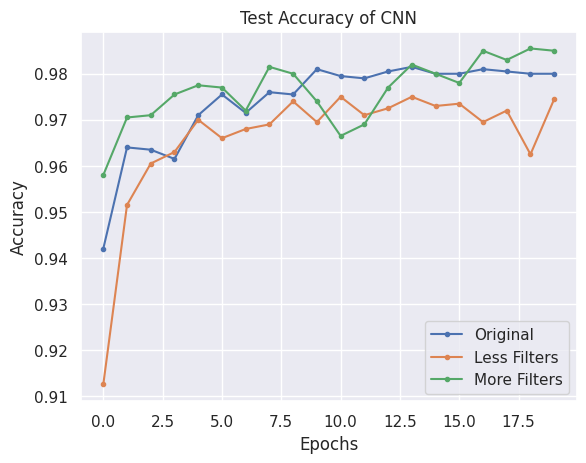

In [ ]:
# Plot the accuracy curves w.r.t. epochs
plt.plot(original[0:20], marker='.', label='Original')
plt.plot(lessFilters[0:20], marker='.',label='Less Filters')
plt.plot(moreFilters[0:20], marker='.',label='More Filters')
plt.legend()
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.title('Test Accuracy of CNN')
plt.show()

In [ ]:
#Add pooling Layers
class CNNnet(torch.nn.Module):
    def __init__(self):
        super(CNNnet,self).__init__()

        self.conv1 = torch.nn.Sequential(
            torch.nn.Conv2d(1,16,3,1,0),  # Double the number of filters from 16 to 32
            torch.nn.BatchNorm2d(16),     # Adjust BatchNorm2d accordingly
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2,2)
        )
        self.conv2 = torch.nn.Sequential(
            torch.nn.Conv2d(16,32,3,1,0), # Double the number of filters from 32 to 64
            torch.nn.BatchNorm2d(32),     # Adjust BatchNorm2d accordingly
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2,2)
        )
        self.conv3 = torch.nn.Sequential(
            torch.nn.Conv2d(32,32,3,1,0), # Double the number of filters from 32 to 64
            torch.nn.BatchNorm2d(32),     # Adjust BatchNorm2d accordingly
            torch.nn.ReLU()
        )
        self.conv4 = torch.nn.Sequential(
            torch.nn.Conv2d(32,64,2,1,0),# Double the number of filters from 64 to 128
            torch.nn.BatchNorm2d(64),    # Adjust BatchNorm2d accordingly
            torch.nn.ReLU()
        )

        self.mlp1 = torch.nn.Linear(2*2*64,100) # input dimension should match the output dimension from the previous layer
        # final output is of dimension 10 since
        # MNIST is a 10-class classification dataset
        self.mlp2 = torch.nn.Linear(100,10)

    # feedforward
    def forward(self,x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        # flatten tensor to 1-D
        x = self.mlp1(x.view(x.size(0),-1))
        x = self.mlp2(x)
        return x
model = CNNnet()

# train the model
pooling = train(model, train_epoch=train_epoch, model_save=model_save, train_loader=train_loader, test_loader=test_loader)

Training Loss:2.282549 Batch 0/100 
Training Loss:0.707897 Batch 20/100 
Training Loss:0.291475 Batch 40/100 
Training Loss:0.236722 Batch 60/100 
Training Loss:0.172472 Batch 80/100 
Epoch 0, Test Accuracy 95.250 %
Training Loss:0.170199 Batch 0/100 
Training Loss:0.051678 Batch 20/100 
Training Loss:0.095751 Batch 40/100 
Training Loss:0.054502 Batch 60/100 
Training Loss:0.031976 Batch 80/100 
Epoch 1, Test Accuracy 97.250 %
Training Loss:0.073969 Batch 0/100 
Training Loss:0.059427 Batch 20/100 
Training Loss:0.049963 Batch 40/100 
Training Loss:0.022246 Batch 60/100 
Training Loss:0.026274 Batch 80/100 
Epoch 2, Test Accuracy 98.150 %
Training Loss:0.012530 Batch 0/100 
Training Loss:0.014719 Batch 20/100 
Training Loss:0.008790 Batch 40/100 
Training Loss:0.028556 Batch 60/100 
Training Loss:0.021195 Batch 80/100 
Epoch 3, Test Accuracy 98.050 %
Training Loss:0.005763 Batch 0/100 
Training Loss:0.010315 Batch 20/100 
Training Loss:0.025865 Batch 40/100 
Training Loss:0.016328 Bat

In [ ]:
#adding dropout layers
class CNNnet(torch.nn.Module):
    def __init__(self):
        super(CNNnet,self).__init__()
        self.conv1 = torch.nn.Sequential(
            torch.nn.Conv2d(1,16,3,2,1),
            torch.nn.BatchNorm2d(16),
            torch.nn.ReLU(),
            # torch.nn.Dropout(p=0.5)
        )
        self.conv2 = torch.nn.Sequential(
            torch.nn.Conv2d(16,32,3,2,1), # be sure to have the number of input channels match the output channels of the previous layer
            torch.nn.BatchNorm2d(32),
            torch.nn.ReLU(),
            # torch.nn.Dropout(p=0.5)
        )
        self.conv3 = torch.nn.Sequential(
            torch.nn.Conv2d(32,32,3,2,1),
            torch.nn.BatchNorm2d(32),
            torch.nn.ReLU(),
            # torch.nn.Dropout(p=0.5)
        )
        self.conv4 = torch.nn.Sequential(
            torch.nn.Conv2d(32,64,2,2,0),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(),
            # torch.nn.Dropout(p=0.5)
        )
        # Define fully connected layers with Dropout
        self.fc = torch.nn.Sequential(
            torch.nn.Linear(2*2*64, 100),
            torch.nn.Dropout(p=0.2),
            torch.nn.ReLU(),
            torch.nn.Linear(100, 10),
            torch.nn.Dropout(p=0.2)
        )

        # # set fully connected layer
        # self.mlp1 = torch.nn.Linear(2*2*64,100) # input dimension should match the output dimension from the previous layer
        # # final output is of dimension 10 since
        # # MNIST is a 10-class classification dataset
        # self.mlp2 = torch.nn.Linear(100,10)

    # feedforward
    def forward(self,x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        # flatten tensor to 1-D
        x = x.view(x.size(0),-1)
        x = self.fc(x)
        # x = self.mlp1(x.view(x.size(0),-1))
        # x = self.mlp2(x)
        return x
model = CNNnet()

# train the model
dropout2 = train(model, train_epoch=train_epoch, model_save=model_save, train_loader=train_loader, test_loader=test_loader)

Training Loss:2.286446 Batch 0/100 
Training Loss:1.529048 Batch 20/100 
Training Loss:0.854076 Batch 40/100 
Training Loss:0.675949 Batch 60/100 
Training Loss:0.636783 Batch 80/100 
Epoch 0, Test Accuracy 93.800 %
Training Loss:0.539549 Batch 0/100 
Training Loss:0.331663 Batch 20/100 
Training Loss:0.374871 Batch 40/100 
Training Loss:0.273732 Batch 60/100 
Training Loss:0.490261 Batch 80/100 
Epoch 1, Test Accuracy 95.600 %
Training Loss:0.265009 Batch 0/100 
Training Loss:0.305675 Batch 20/100 
Training Loss:0.255225 Batch 40/100 
Training Loss:0.423769 Batch 60/100 
Training Loss:0.355152 Batch 80/100 
Epoch 2, Test Accuracy 96.850 %
Training Loss:0.258924 Batch 0/100 
Training Loss:0.274394 Batch 20/100 
Training Loss:0.430485 Batch 40/100 
Training Loss:0.196229 Batch 60/100 
Training Loss:0.224293 Batch 80/100 
Epoch 3, Test Accuracy 96.900 %
Training Loss:0.306347 Batch 0/100 
Training Loss:0.209719 Batch 20/100 
Training Loss:0.291201 Batch 40/100 
Training Loss:0.261356 Bat

In [ ]:
#adding dropout layers
class CNNnet(torch.nn.Module):
    def __init__(self):
        super(CNNnet,self).__init__()
        self.conv1 = torch.nn.Sequential(
            torch.nn.Conv2d(1,16,3,2,1),
            torch.nn.BatchNorm2d(16),
            torch.nn.ReLU(),
            # torch.nn.Dropout(p=0.5)
        )
        self.conv2 = torch.nn.Sequential(
            torch.nn.Conv2d(16,32,3,2,1), # be sure to have the number of input channels match the output channels of the previous layer
            torch.nn.BatchNorm2d(32),
            torch.nn.ReLU(),
            # torch.nn.Dropout(p=0.5)
        )
        self.conv3 = torch.nn.Sequential(
            torch.nn.Conv2d(32,32,3,2,1),
            torch.nn.BatchNorm2d(32),
            torch.nn.ReLU(),
            # torch.nn.Dropout(p=0.5)
        )
        self.conv4 = torch.nn.Sequential(
            torch.nn.Conv2d(32,64,2,2,0),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(),
            # torch.nn.Dropout(p=0.5)
        )
        # Define fully connected layers with Dropout
        self.fc = torch.nn.Sequential(
            torch.nn.Linear(2*2*64, 100),
            torch.nn.Dropout(p=0.5),
            torch.nn.ReLU(),
            torch.nn.Linear(100, 10),
            torch.nn.Dropout(p=0.5)
        )

        # # set fully connected layer
        # self.mlp1 = torch.nn.Linear(2*2*64,100) # input dimension should match the output dimension from the previous layer
        # # final output is of dimension 10 since
        # # MNIST is a 10-class classification dataset
        # self.mlp2 = torch.nn.Linear(100,10)

    # feedforward
    def forward(self,x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        # flatten tensor to 1-D
        x = x.view(x.size(0),-1)
        x = self.fc(x)
        # x = self.mlp1(x.view(x.size(0),-1))
        # x = self.mlp2(x)
        return x
model = CNNnet()

# train the model
dropout5 = train(model, train_epoch=train_epoch, model_save=model_save, train_loader=train_loader, test_loader=test_loader)

Training Loss:2.370482 Batch 0/100 
Training Loss:1.836997 Batch 20/100 
Training Loss:1.554330 Batch 40/100 
Training Loss:1.365238 Batch 60/100 
Training Loss:1.262184 Batch 80/100 
Epoch 0, Test Accuracy 93.450 %
Training Loss:1.366444 Batch 0/100 
Training Loss:1.297850 Batch 20/100 
Training Loss:1.060170 Batch 40/100 
Training Loss:1.106563 Batch 60/100 
Training Loss:1.041987 Batch 80/100 
Epoch 1, Test Accuracy 94.900 %
Training Loss:0.983329 Batch 0/100 
Training Loss:1.127803 Batch 20/100 
Training Loss:1.099552 Batch 40/100 
Training Loss:1.060314 Batch 60/100 
Training Loss:0.826292 Batch 80/100 
Epoch 2, Test Accuracy 96.600 %
Training Loss:0.868885 Batch 0/100 
Training Loss:0.855457 Batch 20/100 
Training Loss:0.850098 Batch 40/100 
Training Loss:1.004794 Batch 60/100 
Training Loss:1.001626 Batch 80/100 
Epoch 3, Test Accuracy 96.100 %
Training Loss:0.967970 Batch 0/100 
Training Loss:0.831808 Batch 20/100 
Training Loss:1.068154 Batch 40/100 
Training Loss:1.018514 Bat

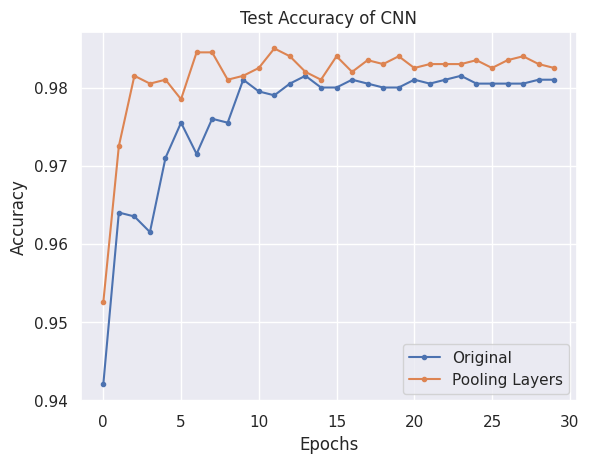

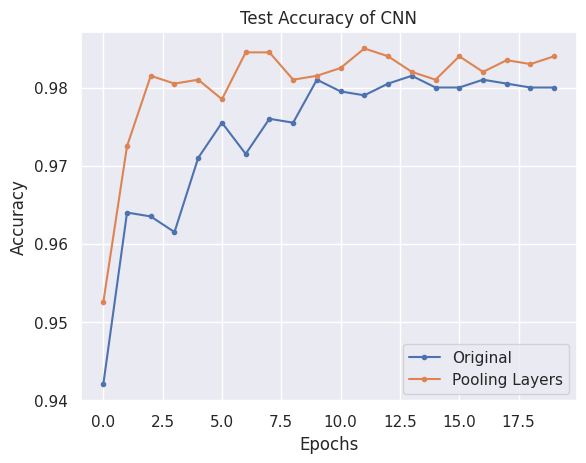

In [ ]:
# Plot the accuracy curves w.r.t. epochs
plt.plot(original, marker='.', label='Original')
plt.plot(pooling, marker='.',label='Pooling Layers')
plt.legend()
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.title('Test Accuracy of CNN')
plt.show()

# Plot the accuracy curves w.r.t. epochs
plt.plot(original[0:20], marker='.', label='Original')
plt.plot(pooling[0:20], marker='.',label='Pooling Layers')
plt.legend()
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.title('Test Accuracy of CNN')
plt.show()

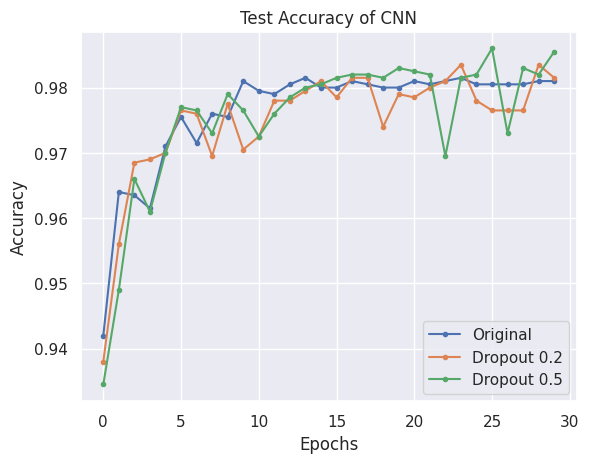

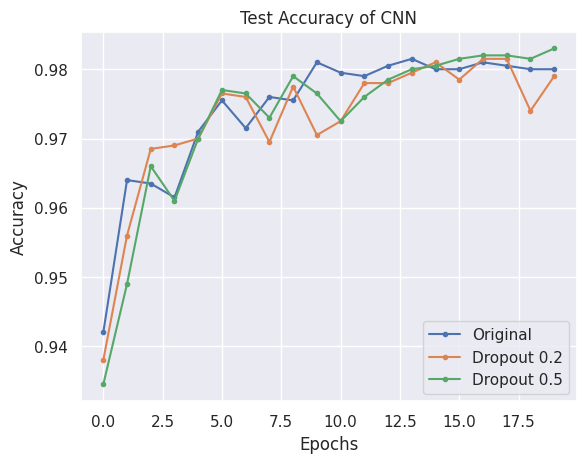

In [ ]:
# Plot the accuracy curves w.r.t. epochs
plt.plot(original, marker='.', label='Original')
plt.plot(dropout2, marker='.',label='Dropout 0.2')
plt.plot(dropout5, marker='.',label='Dropout 0.5')
plt.legend()
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.title('Test Accuracy of CNN')
plt.show()

# Plot the accuracy curves w.r.t. epochs
plt.plot(original[0:20], marker='.', label='Original')
plt.plot(dropout2[0:20], marker='.',label='Dropout 0.2')
plt.plot(dropout5[0:20], marker='.',label='Dropout 0.5')
plt.legend()
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.title('Test Accuracy of CNN')
plt.show()

In [ ]:
#Sigmoid Layers
class CNNnet(torch.nn.Module):
    def __init__(self):
        super(CNNnet,self).__init__()
        self.conv1 = torch.nn.Sequential(
            torch.nn.Conv2d(1,16,3,2,1),
            torch.nn.BatchNorm2d(16),
            torch.nn.Sigmoid()
        )
        self.conv2 = torch.nn.Sequential(
            torch.nn.Conv2d(16,32,3,2,1), # be sure to have the number of input channels match the output channels of the previous layer
            torch.nn.BatchNorm2d(32),
            torch.nn.Sigmoid()
        )
        self.conv3 = torch.nn.Sequential(
            torch.nn.Conv2d(32,32,3,2,1),
            torch.nn.BatchNorm2d(32),
            torch.nn.Sigmoid()
        )
        self.conv4 = torch.nn.Sequential(
            torch.nn.Conv2d(32,64,2,2,0),
            torch.nn.BatchNorm2d(64),
            torch.nn.Sigmoid()
        )

        # set fully connected layer
        self.mlp1 = torch.nn.Linear(2*2*64,100) # input dimension should match the output dimension from the previous layer
        # final output is of dimension 10 since
        # MNIST is a 10-class classification dataset
        self.mlp2 = torch.nn.Linear(100,10)

    # feedforward
    def forward(self,x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        # flatten tensor to 1-D
        x = self.mlp1(x.view(x.size(0),-1))
        x = self.mlp2(x)
        return x
model = CNNnet()

# train the model
sigmoid = train(model, train_epoch=train_epoch, model_save=model_save, train_loader=train_loader, test_loader=test_loader)


Training Loss:2.292233 Batch 0/100 
Training Loss:1.724603 Batch 20/100 
Training Loss:1.127703 Batch 40/100 
Training Loss:0.730793 Batch 60/100 
Training Loss:0.485469 Batch 80/100 
Epoch 0, Test Accuracy 88.000 %
Training Loss:0.352983 Batch 0/100 
Training Loss:0.433775 Batch 20/100 
Training Loss:0.381443 Batch 40/100 
Training Loss:0.185523 Batch 60/100 
Training Loss:0.267889 Batch 80/100 
Epoch 1, Test Accuracy 93.500 %
Training Loss:0.235707 Batch 0/100 
Training Loss:0.183064 Batch 20/100 
Training Loss:0.214713 Batch 40/100 
Training Loss:0.280083 Batch 60/100 
Training Loss:0.249231 Batch 80/100 
Epoch 2, Test Accuracy 93.950 %
Training Loss:0.338839 Batch 0/100 
Training Loss:0.139353 Batch 20/100 
Training Loss:0.129637 Batch 40/100 
Training Loss:0.178143 Batch 60/100 
Training Loss:0.178098 Batch 80/100 
Epoch 3, Test Accuracy 92.050 %
Training Loss:0.165268 Batch 0/100 
Training Loss:0.125536 Batch 20/100 
Training Loss:0.139578 Batch 40/100 
Training Loss:0.236802 Bat

In [ ]:
#Tanh Layers
class CNNnet(torch.nn.Module):
    def __init__(self):
        super(CNNnet,self).__init__()
        self.conv1 = torch.nn.Sequential(
            torch.nn.Conv2d(1,16,3,2,1),
            torch.nn.BatchNorm2d(16),
            torch.nn.Tanh()
        )
        self.conv2 = torch.nn.Sequential(
            torch.nn.Conv2d(16,32,3,2,1), # be sure to have the number of input channels match the output channels of the previous layer
            torch.nn.BatchNorm2d(32),
            torch.nn.Tanh()
        )
        self.conv3 = torch.nn.Sequential(
            torch.nn.Conv2d(32,32,3,2,1),
            torch.nn.BatchNorm2d(32),
            torch.nn.Tanh()
        )
        self.conv4 = torch.nn.Sequential(
            torch.nn.Conv2d(32,64,2,2,0),
            torch.nn.BatchNorm2d(64),
            torch.nn.Tanh()
        )

        # set fully connected layer
        self.mlp1 = torch.nn.Linear(2*2*64,100) # input dimension should match the output dimension from the previous layer
        # final output is of dimension 10 since
        # MNIST is a 10-class classification dataset
        self.mlp2 = torch.nn.Linear(100,10)

    # feedforward
    def forward(self,x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        # flatten tensor to 1-D
        x = self.mlp1(x.view(x.size(0),-1))
        x = self.mlp2(x)
        return x
model = CNNnet()

# train the model
tanh = train(model, train_epoch=train_epoch, model_save=model_save, train_loader=train_loader, test_loader=test_loader)


Training Loss:2.298103 Batch 0/100 
Training Loss:0.745307 Batch 20/100 
Training Loss:0.428582 Batch 40/100 
Training Loss:0.268734 Batch 60/100 
Training Loss:0.278798 Batch 80/100 
Epoch 0, Test Accuracy 92.350 %
Training Loss:0.135495 Batch 0/100 
Training Loss:0.259402 Batch 20/100 
Training Loss:0.167284 Batch 40/100 
Training Loss:0.148945 Batch 60/100 
Training Loss:0.108963 Batch 80/100 
Epoch 1, Test Accuracy 95.600 %
Training Loss:0.122530 Batch 0/100 
Training Loss:0.117016 Batch 20/100 
Training Loss:0.131934 Batch 40/100 
Training Loss:0.076012 Batch 60/100 
Training Loss:0.126702 Batch 80/100 
Epoch 2, Test Accuracy 96.300 %
Training Loss:0.131480 Batch 0/100 
Training Loss:0.041693 Batch 20/100 
Training Loss:0.180065 Batch 40/100 
Training Loss:0.160510 Batch 60/100 
Training Loss:0.061220 Batch 80/100 
Epoch 3, Test Accuracy 96.050 %
Training Loss:0.021770 Batch 0/100 
Training Loss:0.039007 Batch 20/100 
Training Loss:0.054547 Batch 40/100 
Training Loss:0.033745 Bat

In [ ]:
#Leaky ReLu
class CNNnet(torch.nn.Module):
    def __init__(self):
        super(CNNnet,self).__init__()
        self.conv1 = torch.nn.Sequential(
            torch.nn.Conv2d(1,16,3,2,1),
            torch.nn.BatchNorm2d(16),
            torch.nn.LeakyReLU()
        )
        self.conv2 = torch.nn.Sequential(
            torch.nn.Conv2d(16,32,3,2,1), # be sure to have the number of input channels match the output channels of the previous layer
            torch.nn.BatchNorm2d(32),
            torch.nn.LeakyReLU()
        )
        self.conv3 = torch.nn.Sequential(
            torch.nn.Conv2d(32,32,3,2,1),
            torch.nn.BatchNorm2d(32),
            torch.nn.LeakyReLU()
        )
        self.conv4 = torch.nn.Sequential(
            torch.nn.Conv2d(32,64,2,2,0),
            torch.nn.BatchNorm2d(64),
            torch.nn.LeakyReLU()
        )

        # set fully connected layer
        self.mlp1 = torch.nn.Linear(2*2*64,100) # input dimension should match the output dimension from the previous layer
        # final output is of dimension 10 since
        # MNIST is a 10-class classification dataset
        self.mlp2 = torch.nn.Linear(100,10)

    # feedforward
    def forward(self,x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        # flatten tensor to 1-D
        x = self.mlp1(x.view(x.size(0),-1))
        x = self.mlp2(x)
        return x
model = CNNnet()

# train the model
leaky = train(model, train_epoch=train_epoch, model_save=model_save, train_loader=train_loader, test_loader=test_loader)

Training Loss:2.345803 Batch 0/100 
Training Loss:0.871998 Batch 20/100 
Training Loss:0.316555 Batch 40/100 
Training Loss:0.431095 Batch 60/100 
Training Loss:0.233635 Batch 80/100 
Epoch 0, Test Accuracy 94.750 %
Training Loss:0.083029 Batch 0/100 
Training Loss:0.126060 Batch 20/100 
Training Loss:0.140978 Batch 40/100 
Training Loss:0.050154 Batch 60/100 
Training Loss:0.071354 Batch 80/100 
Epoch 1, Test Accuracy 96.600 %
Training Loss:0.031528 Batch 0/100 
Training Loss:0.045877 Batch 20/100 
Training Loss:0.019333 Batch 40/100 
Training Loss:0.083130 Batch 60/100 
Training Loss:0.062255 Batch 80/100 
Epoch 2, Test Accuracy 97.100 %
Training Loss:0.106335 Batch 0/100 
Training Loss:0.023381 Batch 20/100 
Training Loss:0.047552 Batch 40/100 
Training Loss:0.074539 Batch 60/100 
Training Loss:0.125669 Batch 80/100 
Epoch 3, Test Accuracy 97.400 %
Training Loss:0.011204 Batch 0/100 
Training Loss:0.057890 Batch 20/100 
Training Loss:0.034243 Batch 40/100 
Training Loss:0.004721 Bat

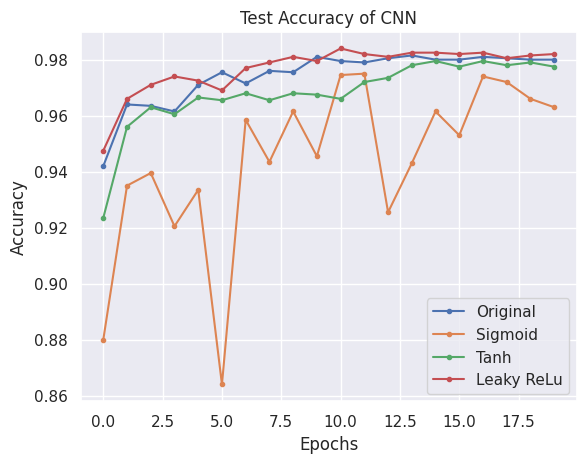

In [ ]:
# Plot the accuracy curves w.r.t. epochs
plt.plot(original[0:20], marker='.', label='Original')
plt.plot(sigmoid[0:20], marker='.',label='Sigmoid')
plt.plot(tanh[0:20], marker='.',label='Tanh')
plt.plot(leaky[0:20], marker='.',label='Leaky ReLu')
plt.legend()
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.title('Test Accuracy of CNN')
plt.show()